# Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.transforms.functional as TF

from sklearn.cluster import KMeans

import numpy as np

import matplotlib.pyplot as plt

from google.colab import drive

import random

from os import listdir
from os.path import isfile, join

from tqdm import tqdm

# Utils

In [ ]:
class CustomDataset():
    
    def __init__(self, dataset, transform=None):
        
        self.images    = []
        self.targets   = []
        self.transform = transform

        for i in range(len(dataset)):

            self.images.append(dataset[i][0])
            self.targets.append(dataset[i][1])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        
        image  = self.images[index] 
        target = self.targets[index] 
        
        if self.transform:
            image = self.transform(image)
            
        return (image, index, target)

In [ ]:
def cluster_test(dataset, model, clu=3):

    valid_loader = torch.utils.data.DataLoader(dataset, batch_size=8, num_workers=0, shuffle=False)
    o, l = [], []
    lab, out = [], []

    model.eval()

    for inputs in valid_loader:        

        images, labels = inputs
        images = images.to(device)

        output = model.encoder(images.float())
        # output = model.fce(output, output.shape[0])
        output = output.to("cpu")
        output = torch.mean(output, dim = (-2, -1))

        output = output.detach().numpy()
        labels = labels.numpy()

        o.append(output)
        l.append(labels)    

    for i in range(len(l)):
        for j in range(len(o[i])):
            lab.append(l[i][j])
            out.append(o[i][j])

    kmeans = KMeans(n_clusters=clu, init='k-means++', n_init=10, max_iter=300, tol=0.01, verbose=0, random_state=None, copy_x=True, algorithm='elkan')
    label = kmeans.fit_predict(out)

    i00, i01, i02, i03 = 0, 0, 0, 0
    i10, i11, i12, i13 = 0, 0, 0, 0
    i20, i21, i22, i23 = 0, 0, 0, 0
    i30, i31, i32, i33 = 0, 0, 0, 0

    for i in range(len(label)):

        if lab[i] == 0 and label[i] == 0:
            i00 += 1
        if lab[i] == 0 and label[i] == 1:
            i01 += 1
        if lab[i] == 0 and label[i] == 2:
            i02 += 1
        if lab[i] == 0 and label[i] == 3:
            i03 += 1

        if lab[i] == 1 and label[i] == 0:
            i10 += 1
        if lab[i] == 1 and label[i] == 1:
            i11 += 1
        if lab[i] == 1 and label[i] == 2:
            i12 += 1
        if lab[i] == 1 and label[i] == 3:
            i13 += 1

        if lab[i] == 2 and label[i] == 0:
            i20 += 1
        if lab[i] == 2 and label[i] == 1:
            i21 += 1
        if lab[i] == 2 and label[i] == 2:
            i22 += 1
        if lab[i] == 2 and label[i] == 3:
            i23 += 1

        if lab[i] == 3 and label[i] == 0:
            i30 += 1
        if lab[i] == 3 and label[i] == 1:
            i31 += 1
        if lab[i] == 3 and label[i] == 2:
            i32 += 1
        if lab[i] == 3 and label[i] == 3:
            i33 += 1

    p = [[i00, i01, i02, i03],
         [i10, i11, i12, i13],
         [i20, i21, i22, i23],
         [i30, i31, i32, i33]]

    return p

In [ ]:
def transform_signal(img_one, inteiro=False, show=False, random=False, dobro=False, layers=11):

    meio = np.mean(img_one, axis=0)
    a = np.asarray(img_one)

    if len(img_one) < layers:
        num = layers - len(img_one)

        for i in range(num):
            a = np.vstack((a, meio))


    '''
    img = []
    if dobro:
        for i in img_one:
            img.append(i)
            img.append(i)
        a = np.asarray(img)
    else:      
        a = img_one
    '''
    
    if random: np.random.shuffle(a)

    if inteiro: a = np.interp(a, (np.min(a), np.max(a)), (0, 1))


    if show:
        fig, ax = plt.subplots(figsize=(5,1))
        ax.imshow(np.transpose(a, (0, 1)), aspect='auto') 
        plt.show()

    return a

In [ ]:
def check_accuracy(loader, model):
    
    valid_loss = 0
        
    model.eval()
    
    with torch.no_grad():
        
        for data in loader:
            
            images, _, _ = data
            images       = images.to(device).float()
            
            outputs = model(images)          
            loss    = criterion(outputs.float(), images.float())

            valid_loss += loss.item()*images.size(0)
    
        valid_loss = valid_loss/len(loader)
    
    return valid_loss

In [ ]:
def precision_matrix(matrix):    
    
    np_matrix = np.array(matrix)
    soma = 0

    soma += np_matrix.max()
    row, col = int(np_matrix.argmax() / 4), int(np_matrix.argmax() % 4)
    b = np.delete(np_matrix, row, 0)
    b = np.delete(b, col, 1)

    soma += b.max()
    row, col = int(b.argmax() / 3), int(b.argmax() % 3)
    b = np.delete(b, row, 0)
    b = np.delete(b, col, 1)

    soma += b.max()
    row, col = int(b.argmax() / 2), int(b.argmax() % 2)
    b = np.delete(b, row, 0)
    b = np.delete(b, col, 1)
    
    soma += b[0][0]
    
    return (100 * soma) / np_matrix.sum()

In [ ]:
precision_matrix([[8, 0, 1, 21], [0, 9, 9, 0], [1, 1, 1, 0], [2, 1, 1, 1]])

58.92857142857143

# Data and Google Drive - Eu e Gabriel

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
pathPG = "/content/drive/MyDrive/Guilherme/pre_teste/PG/verificados"
pathPC = "/content/drive/MyDrive/Guilherme/pre_teste/PC/verificados"

In [ ]:
mypath_PG = pathPG
PG_names = [f for f in listdir(mypath_PG) if isfile(join(mypath_PG, f))]

mypath_PC = pathPC
PC_names = [f for f in listdir(mypath_PC) if isfile(join(mypath_PC, f))]

In [ ]:
dataset_PG, dataset_PC = [], []

for name in tqdm(PG_names):
    
    data = np.genfromtxt(mypath_PG + "/" + name, delimiter=',')
    data = data[1:]
    data = np.expand_dims(data, axis=0)
    
    dataset_PG.append(data)

for name in tqdm(PC_names):
    
    data = np.genfromtxt(mypath_PC + "/" + name, delimiter=',')
    data = data[1:]
    data = np.expand_dims(data, axis=0)
    
    dataset_PC.append(data)

100%|██████████| 340/340 [01:19<00:00,  4.30it/s]


In [ ]:
print(dataset_PC[0][0][0])

[60.02768266 60.02657147 60.02657147 60.02657147 60.02657147 60.02657147
 60.02657147 60.02657147 60.02669993 60.02657147 60.02657147 60.02657147
 60.03010564 60.02570428 60.02657147 60.02657147 60.02361584 60.02382068
 60.02657147 60.02432814 60.02983045 60.02657147 60.02657147 60.02735554]


In [ ]:
# 0, 
for j in range(20, 60):
    bb = np.transpose(dataset_PC[j][0][:][0:1200], (1,0))

    plt.figure(figsize=(8, 4))

    for i in range(len(bb)):
      plt.plot(bb[i])

    plt.title('Gráfico de Perda de Carga: ' + str(j))

    plt.grid(True)
    plt.show()

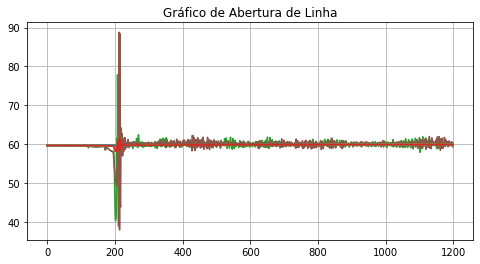

In [ ]:
bb = np.transpose(dataset_PC[54][0][:][0:1200], (1,0))

plt.figure(figsize=(8, 4))

for i in range(len(bb)):
  plt.plot(bb[i])

plt.title('Gráfico de Abertura de Linha')

plt.grid(True)
plt.show()

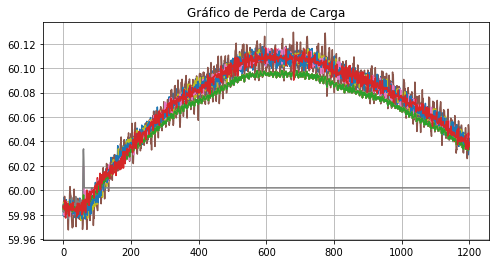

In [ ]:
bb = np.transpose(dataset_PC[4][0][:][0:1200], (1,0))

plt.figure(figsize=(8, 4))

for i in range(len(bb)):
  plt.plot(bb[i])

plt.title('Gráfico de Perda de Carga')

plt.grid(True)
plt.show()

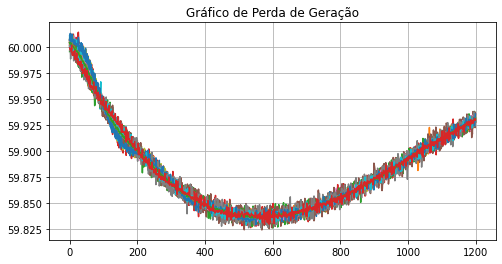

In [ ]:
bb = np.transpose(dataset_PG[50][0][:][0:1600], (1,0))

plt.figure(figsize=(8, 4))

for i in range(len(bb)):
  plt.plot(bb[i])

plt.title('Gráfico de Perda de Geração')

plt.grid(True)
plt.show()

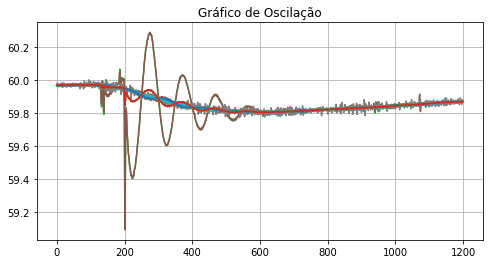

In [ ]:
bb = np.transpose(dataset_PG[100][0][:][0:1200], (1,0))

plt.figure(figsize=(8, 4))

for i in range(len(bb)):
  plt.plot(bb[i])

plt.title('Gráfico de Oscilação')

plt.grid(True)
plt.show()

In [ ]:
t = np.asarray(dataset_PC[0])
t.shape

(1, 1200, 24)

In [ ]:
PC_torch, PG_torch= [], []

for itemPC in dataset_PC:
    PC_torch.append([transform_signal(np.transpose(itemPC[0][:][0:1200:4], (1,0)), inteiro=True, show=False, random=False, dobro=False, layers=24)])

for itemPG in dataset_PG:
    PG_torch.append([transform_signal(np.transpose(itemPG[0][:][0:1200:4], (1,0)), inteiro=True, show=False, random=False, dobro=False, layers=24)])


PC_torch = torch.tensor(PC_torch)
PG_torch = torch.tensor(PG_torch)

complete_set = []
train_set, valid_set = [], []
train_size = 200

for counter, value in enumerate(PC_torch):
    imagem = (value, 1)
    complete_set.append(imagem)

    if counter < train_size:
        train_set.append(imagem)
    else:
        valid_set.append(imagem)

for counter, value in enumerate(PG_torch):
    imagem = (value, 0)
    complete_set.append(imagem)

    if counter < train_size:
        train_set.append(imagem)
    else:
        valid_set.append(imagem)

print(f'Shape:      {complete_set[0][0].shape}')
print(f'Train Size: {len(train_set)}')
print(f'Valid Size: {len(valid_set)}\n')
print(f'Relação de treino/validação: {100*len(train_set)/len(valid_set) : .2f}')

Shape:      torch.Size([1, 24, 300])
Train Size: 400
Valid Size: 227

Relação de treino/validação:  176.21


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  # Remove the CWD from sys.path while we load stuff.


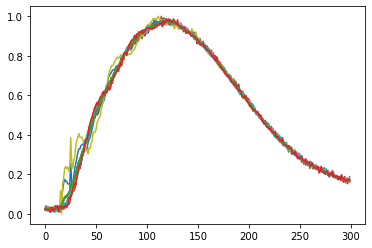

In [ ]:
for i in range(len(complete_set[0][0][0])):
  plt.plot(complete_set[3][0][0][i])

plt.show()

# Data and Google Drive - Orlem

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/Guilherme/archive/TestComp_Events.npz"
dt = np.load(path, allow_pickle=True)

In [ ]:
di = {'PG'  : 0,
      'RC'  : 1,
      'DLT' : 2,
      'OS'  : 2}

dataset = []
min_layer = 1

nan_list = []

for alvo in range(len(dt['list'])):

    nu = np.asarray(dt['list'][alvo][:1200])
    t = np.transpose(nu, (1,0))

    if len(t) >= min_layer and not np.any(np.isnan(t)):
        dataset.append((t[:8], di[dt['target'][alvo]]))

    if np.any(np.isnan(t)):
        nan_list.append(alvo)

data_torch = []

for data in dataset:
    data_torch.append([transform_signal(data[0], inteiro=True, show=False, random=False, dobro=False, layers=8)])  

data_torch = torch.tensor(data_torch)
print(data_torch.shape)

complete_set = []

for alvo in range(len(data_torch)):

    complete_set.append((data_torch[alvo], dataset[alvo][1]))

torch.Size([65, 1, 8, 1200])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)


In [ ]:
for i in range(len(dt['list'])):

    nu = np.asarray(dt['list'][i][:1200])
    t = np.transpose(nu, (1,0))

    print(i, len(t))

0 19
1 16
2 18
3 19
4 18
5 15
6 15
7 15
8 17
9 16
10 17
11 16
12 15
13 16
14 14
15 14
16 19
17 16
18 20
19 19
20 18
21 20
22 20
23 17
24 19
25 19
26 17
27 21
28 17
29 14
30 17
31 18
32 19
33 18
34 14
35 18
36 16
37 20
38 19
39 19
40 22
41 19
42 19
43 19
44 19
45 16
46 21
47 20
48 2
49 1
50 1
51 1
52 1
53 1
54 2
55 1
56 1
57 1
58 2
59 2
60 1
61 2
62 2
63 2
64 1
65 2
66 2


In [ ]:
nan_list

[58, 64]

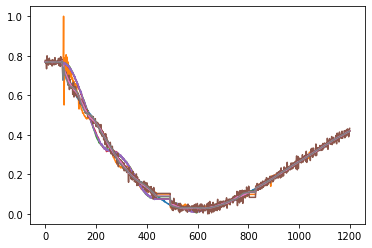

In [ ]:
plt.plot(np.transpose(complete_set[20][0][0], (1,0)))
plt.show()

# Model

In [ ]:
# Define model of double convolution

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        
        self.conv = nn.Sequential(
        
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))
        
    def forward(self, x):
        return self.conv(x)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_channels, features=[64, 128, 256, 512]):
        super(Encoder, self).__init__()
        
        self.downs = nn.ModuleList()
        self.pool  = nn.MaxPool2d(kernel_size=2, stride=2)
        
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature
            
        
        
    def forward(self, x):

        self.skip_connections = []
        
        for down in self.downs:
            x = down(x)
            self.skip_connections.append(x)
            x = self.pool(x)
        
        return x

In [ ]:
class EncoderFC(nn.Module):
    def __init__(self, features=512):
        super(EncoderFC, self).__init__()

        self.features = features

        self.fci1  = nn.Sequential(nn.Linear(features*2*300, features*2),
                                   nn.ReLU(),
                                   nn.Linear(features*2, features),
                                   nn.ReLU(),
                                   nn.Linear(features, 1024))
        
        
        
    def forward(self, x, s):

        x = x.reshape(s, -1)

        # x = torch.mean(x, dim = (-2, -1))
        # print(x.shape)

        x = self.fci1(x)
        
        return x

In [ ]:
class DecoderFC(nn.Module):
    def __init__(self, features=512):
        super(DecoderFC, self).__init__()

        self.features = features
        self.fci2 = nn.Sequential(nn.Linear(1024, features*2),
                                  nn.ReLU(),
                                  nn.Linear(features*2, features*2*300),
                                  nn.ReLU())
        
        
        
    def forward(self, x, s):

        x = self.fci2(x)

        x = x.reshape(s, self.features, 2, 300)
        
        return x

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, features):
        super(UNet, self).__init__()
        
        self.encoder = Encoder(in_channels, features)
        self.ups     = nn.ModuleList()

        self.fce     = EncoderFC(128)
        self.fcd     = DecoderFC(128)
        
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature*2, feature))
            
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        
        
        
    def forward(self, x):

        self.decoder_skip_connections = []
        
        x = self.encoder(x)



        # s = x.shape[0]
        # print(x.shape)
        # x = self.fce(x, s)
        # x = self.fcd(x, s)
        
        x = self.bottleneck(x)
        
        self.decoder_skip_connections.append(x)

        
        self.encoder_skip_connections = self.encoder.skip_connections[::-1]
        
        for i in range(0, len(self.ups), 2):
            
            x = self.ups[i](x)
            
            self.decoder_skip_connections.append(x)
        
            skip_connection = self.encoder_skip_connections[i//2]
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])
                
            concat_skip = torch.cat((skip_connection, x), dim=1)
            
            x = self.ups[i+1](concat_skip)
        
        return self.final_conv(x)

# Treino

In [ ]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

#Instantiate the model
model = UNet(1, 1, [64, 128, 256])

device = get_device()
# print(device)
model = model.to(device)

In [ ]:
args = {'batch_size'          : 8,
        'lr'                  : 0.01,
        'weight_decay'        : 0.0,
        'n_epochs'            : 50
        }

In [ ]:
cs = CustomDataset(complete_set)

train_loader = torch.utils.data.DataLoader(cs, batch_size=args['batch_size'], num_workers=0, shuffle=True)

In [ ]:
criterion = nn.L1Loss().to(device)
optimizer = optim.SGD(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

In [ ]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

n_epochs = args['n_epochs']
loss_per_epoch_train, cluster_precision_per_epoch = [], []

for epoch in range(1, n_epochs+1):
      
    # monitor training loss
    train_loss = 0.0

    model.train()

    #Training
    for data in train_loader:

            
        images, _, _ = data
        images    = images.to(device).float()
        optimizer.zero_grad()  
        
        # Forward

        outputs = model(images)
        loss = criterion(outputs.float(), images.float())

        #Backward
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)

    train_loss = train_loss/len(train_loader)
    loss_per_epoch_train.append(train_loss)    

    cluster_result = cluster_test(complete_set, model, clu=2)
    cluster_precision = precision_matrix(cluster_result)
    cluster_precision_per_epoch.append(cluster_precision)
    
    '''
    di = {'PG'  : 0,
          'RC'  : 1,
          'DLT' : 2,
          'OS'  : 3}
    '''

    
    if epoch % 100 == 0:
        print(f'Epoch {epoch} =================================================================================== <- SAVE\n')
        print(f'PG:  {cluster_result[0]}')
        print(f'RC:  {cluster_result[1]}')
        print(f'DLT: {cluster_result[2]}')
        print(f'OS:  {cluster_result[3]}')
        print(f'\nTraining Loss: {train_loss:.6f}\t\tCluster Precision: {cluster_precision: .2f}%\n') 
        torch.save(model.state_dict(), '/content/drive/MyDrive/Guilherme/MODEL_SAVE_v1/AE_' + str(epoch) + '.pth.tar')
    else:
        print(f'Epoch {epoch} ===================================================================================\n')
        print(f'PG:  {cluster_result[0]}')
        print(f'RC:  {cluster_result[1]}')
        print(f'DLT: {cluster_result[2]}')
        print(f'OS:  {cluster_result[3]}')
        print(f'\nTraining Loss: {train_loss:.6f}\t\tCluster Precision: {cluster_precision: .2f}%\n')


plt.plot(cluster_precision_per_epoch, label='Train')
plt.show()

plt.plot(loss_per_epoch_train, label='Train')
plt.show()

Epoch 1 ===================================================================================

PG:  [18, 269, 0, 0]
RC:  [64, 276, 0, 0]
DLT: [0, 0, 0, 0]
OS:  [0, 0, 0, 0]

Training Loss: 1.096652		Cluster Precision:  46.89%

Epoch 2 ===================================================================================

PG:  [269, 18, 0, 0]
RC:  [277, 63, 0, 0]
DLT: [0, 0, 0, 0]
OS:  [0, 0, 0, 0]

Training Loss: 0.589640		Cluster Precision:  47.05%

Epoch 3 ===================================================================================

PG:  [18, 269, 0, 0]
RC:  [66, 274, 0, 0]
DLT: [0, 0, 0, 0]
OS:  [0, 0, 0, 0]

Training Loss: 0.561722		Cluster Precision:  46.57%

Epoch 4 ===================================================================================

PG:  [271, 16, 0, 0]
RC:  [273, 67, 0, 0]
DLT: [0, 0, 0, 0]
OS:  [0, 0, 0, 0]

Training Loss: 0.488357		Cluster Precision:  46.09%

Epoch 5 ===================================================================================

PG:  [2

Epoch 1 ===================================================================================

PG:  [0, 18, 11, 1]
RC:  [15, 0, 0, 3]
DLT: [2, 3, 0, 7]
OS:  [1, 2, 0, 2]

Training Loss: 1.694985		Cluster Precision:  61.54%

Epoch 2 ===================================================================================

PG:  [1, 11, 0, 18]
RC:  [0, 0, 18, 0]
DLT: [7, 0, 2, 3]
OS:  [2, 0, 1, 2]

Training Loss: 0.894942		Cluster Precision:  66.15%

Epoch 3 ===================================================================================

PG:  [0, 19, 10, 1]
RC:  [18, 0, 0, 0]
DLT: [2, 3, 0, 7]
OS:  [1, 2, 0, 2]

Training Loss: 0.725265		Cluster Precision:  67.69%

Epoch 4 ===================================================================================

PG:  [25, 0, 1, 4]
RC:  [0, 18, 0, 0]
DLT: [0, 2, 7, 3]
OS:  [0, 1, 2, 2]

Training Loss: 0.575634		Cluster Precision:  80.00%

Epoch 5 ===================================================================================

PG:  [29, 0, 1, 0]
R

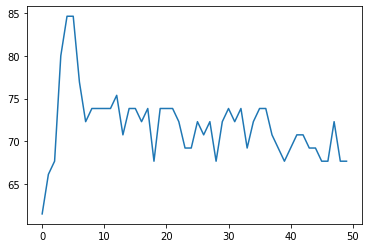

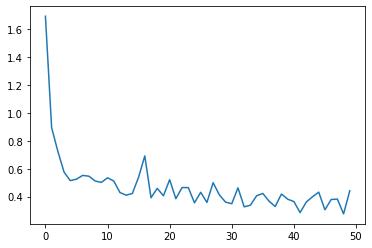

In [ ]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

n_epochs = args['n_epochs']
loss_per_epoch_train, cluster_precision_per_epoch = [], []

for epoch in range(1, n_epochs+1):
      
    # monitor training loss
    train_loss = 0.0

    model.train()

    #Training
    for data in train_loader:

            
        images, _, _ = data
        images    = images.to(device).float()
        optimizer.zero_grad()  
        
        # Forward

        outputs = model(images)
        loss = criterion(outputs.float(), images.float())

        #Backward
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)

    train_loss = train_loss/len(train_loader)
    loss_per_epoch_train.append(train_loss)    

    cluster_result = cluster_test(complete_set, model, clu=4)
    cluster_precision = precision_matrix(cluster_result)
    cluster_precision_per_epoch.append(cluster_precision)
    '''
    di = {'PG'  : 0,
          'RC'  : 1,
          'DLT' : 2,
          'OS'  : 3}
    '''

    
    if epoch % 100 == 0:
        print(f'Epoch {epoch} =================================================================================== <- SAVE\n')
        print(f'PG:  {cluster_result[0]}')
        print(f'RC:  {cluster_result[1]}')
        print(f'DLT: {cluster_result[2]}')
        print(f'OS:  {cluster_result[3]}')
        print(f'\nTraining Loss: {train_loss:.6f}\t\tCluster Precision: {cluster_precision: .2f}%\n') 
        torch.save(model.state_dict(), '/content/drive/MyDrive/Guilherme/MODEL_SAVE_v1/AE_' + str(epoch) + '.pth.tar')
    else:
        print(f'Epoch {epoch} ===================================================================================\n')
        print(f'PG:  {cluster_result[0]}')
        print(f'RC:  {cluster_result[1]}')
        print(f'DLT: {cluster_result[2]}')
        print(f'OS:  {cluster_result[3]}')
        print(f'\nTraining Loss: {train_loss:.6f}\t\tCluster Precision: {cluster_precision: .2f}%\n')


plt.plot(cluster_precision_per_epoch, label='Train')
plt.show()

plt.plot(loss_per_epoch_train, label='Train')
plt.show()

In [ ]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

n_epochs = args['n_epochs']
loss_per_epoch_train, cluster_precision_per_epoch = [], []

for epoch in range(1, n_epochs+1):
      
    # monitor training loss
    train_loss = 0.0

    model.train()

    #Training
    for data in train_loader:

            
        images, _, _ = data
        images    = images.to(device).float()
        optimizer.zero_grad()  
        
        # Forward

        outputs = model(images)
        loss = criterion(outputs.float(), images.float())

        #Backward
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)

    train_loss = train_loss/len(train_loader)
    loss_per_epoch_train.append(train_loss)    

    cluster_result = cluster_test(complete_set, model, clu=4)
    cluster_precision = precision_matrix(cluster_result)
    cluster_precision_per_epoch.append(cluster_precision)
    '''
    di = {'PG'  : 0,
          'RC'  : 1,
          'DLT' : 2,
          'OS'  : 3}
    '''

    
    if epoch % 100 == 0:
        print(f'Epoch {epoch} =================================================================================== <- SAVE\n')
        print(f'PG:  {cluster_result[0]}')
        print(f'RC:  {cluster_result[1]}')
        print(f'DLT: {cluster_result[2]}')
        print(f'OS:  {cluster_result[3]}')
        print(f'\nTraining Loss: {train_loss:.6f}\t\tCluster Precision: {cluster_precision: .2f}%\n') 
        torch.save(model.state_dict(), '/content/drive/MyDrive/Guilherme/MODEL_SAVE_v1/AE_' + str(epoch) + '.pth.tar')
    else:
        print(f'Epoch {epoch} ===================================================================================\n')
        print(f'PG:  {cluster_result[0]}')
        print(f'RC:  {cluster_result[1]}')
        print(f'DLT: {cluster_result[2]}')
        print(f'OS:  {cluster_result[3]}')
        print(f'\nTraining Loss: {train_loss:.6f}\t\tCluster Precision: {cluster_precision: .2f}%\n')


plt.plot(cluster_precision_per_epoch, label='Train')
plt.show()

plt.plot(loss_per_epoch_train, label='Train')
plt.show()

Epoch 1 ===================================================================================

PG:  [1, 22, 0, 7]
RC:  [4, 0, 14, 0]
DLT: [5, 0, 4, 3]
OS:  [1, 0, 2, 2]

Training Loss: 3.344306		Cluster Precision:  66.15%

Epoch 2 ===================================================================================

PG:  [1, 29, 0, 0]
RC:  [8, 0, 10, 0]
DLT: [4, 3, 1, 4]
OS:  [1, 2, 1, 1]

Training Loss: 1.587675		Cluster Precision:  67.69%



KeyboardInterrupt: ignored

Epoch 1 ===================================================================================

PG:  [0, 29, 0, 1]
RC:  [10, 0, 0, 8]
DLT: [1, 3, 4, 4]
OS:  [1, 2, 1, 1]

Training Loss: 3.802009		Cluster Precision:  67.69%

Epoch 2 ===================================================================================

PG:  [29, 0, 0, 1]
RC:  [0, 10, 0, 8]
DLT: [3, 3, 4, 2]
OS:  [2, 1, 1, 1]

Training Loss: 1.034166		Cluster Precision:  67.69%

Epoch 3 ===================================================================================

PG:  [29, 1, 0, 0]
RC:  [0, 8, 0, 10]
DLT: [3, 3, 5, 1]
OS:  [2, 1, 1, 1]

Training Loss: 0.792813		Cluster Precision:  69.23%

Epoch 4 ===================================================================================

PG:  [1, 29, 0, 0]
RC:  [8, 0, 0, 10]
DLT: [3, 3, 5, 1]
OS:  [1, 2, 1, 1]

Training Loss: 0.684469		Cluster Precision:  69.23%

Epoch 5 ===================================================================================

PG:  [29, 1, 0, 0]
RC: 

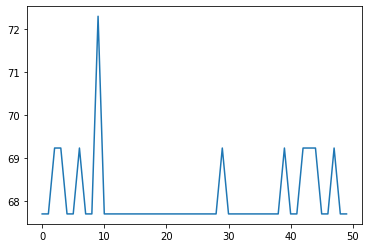

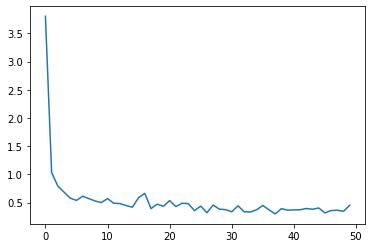

In [ ]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

n_epochs = args['n_epochs']
loss_per_epoch_train, cluster_precision_per_epoch = [], []

for epoch in range(1, n_epochs+1):
      
    # monitor training loss
    train_loss = 0.0

    model.train()

    #Training
    for data in train_loader:

            
        images, _, _ = data
        images    = images.to(device).float()
        optimizer.zero_grad()  
        
        # Forward

        outputs = model(images)
        loss = criterion(outputs.float(), images.float())

        #Backward
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)

    train_loss = train_loss/len(train_loader)
    loss_per_epoch_train.append(train_loss)    

    cluster_result = cluster_test(complete_set, model, clu=4)
    cluster_precision = precision_matrix(cluster_result)
    cluster_precision_per_epoch.append(cluster_precision)
    '''
    di = {'PG'  : 0,
          'RC'  : 1,
          'DLT' : 2,
          'OS'  : 3}
    '''

    
    if epoch % 100 == 0:
        print(f'Epoch {epoch} =================================================================================== <- SAVE\n')
        print(f'PG:  {cluster_result[0]}')
        print(f'RC:  {cluster_result[1]}')
        print(f'DLT: {cluster_result[2]}')
        print(f'OS:  {cluster_result[3]}')
        print(f'\nTraining Loss: {train_loss:.6f}\t\tCluster Precision: {cluster_precision: .2f}%\n') 
        torch.save(model.state_dict(), '/content/drive/MyDrive/Guilherme/MODEL_SAVE_v1/AE_' + str(epoch) + '.pth.tar')
    else:
        print(f'Epoch {epoch} ===================================================================================\n')
        print(f'PG:  {cluster_result[0]}')
        print(f'RC:  {cluster_result[1]}')
        print(f'DLT: {cluster_result[2]}')
        print(f'OS:  {cluster_result[3]}')
        print(f'\nTraining Loss: {train_loss:.6f}\t\tCluster Precision: {cluster_precision: .2f}%\n')


plt.plot(cluster_precision_per_epoch, label='Train')
plt.show()

plt.plot(loss_per_epoch_train, label='Train')
plt.show()

Epoch 1 ===================================================================================

PG:  [8, 0, 1, 21]
RC:  [0, 9, 9, 0]
DLT: [1, 1, 1, 0]
OS:  [2, 1, 1, 1]

Training Loss: 1.932839		Cluster Precision:  58.93%

Epoch 2 ===================================================================================

PG:  [22, 0, 1, 7]
RC:  [0, 10, 8, 0]
DLT: [0, 1, 1, 1]
OS:  [1, 1, 1, 2]

Training Loss: 0.872889		Cluster Precision:  62.50%

Epoch 3 ===================================================================================

PG:  [29, 0, 1, 0]
RC:  [0, 13, 5, 0]
DLT: [1, 1, 1, 0]
OS:  [2, 0, 2, 1]

Training Loss: 0.840699		Cluster Precision:  78.57%

Epoch 4 ===================================================================================

PG:  [1, 25, 0, 4]
RC:  [8, 0, 10, 0]
DLT: [2, 1, 0, 0]
OS:  [1, 2, 1, 1]

Training Loss: 0.646041		Cluster Precision:  67.86%

Epoch 5 ===================================================================================

PG:  [25, 0, 1, 4]
RC:  

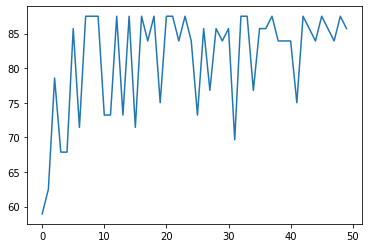

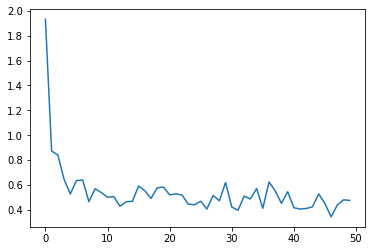

In [ ]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

n_epochs = args['n_epochs']
loss_per_epoch_train, cluster_precision_per_epoch = [], []

for epoch in range(1, n_epochs+1):
      
    # monitor training loss
    train_loss = 0.0

    model.train()

    #Training
    for data in train_loader:

            
        images, _, _ = data
        images    = images.to(device).float()
        optimizer.zero_grad()  
        
        # Forward

        outputs = model(images)
        loss = criterion(outputs.float(), images.float())

        #Backward
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)

    train_loss = train_loss/len(train_loader)
    loss_per_epoch_train.append(train_loss)    

    cluster_result = cluster_test(complete_set, model, clu=4)
    cluster_precision = precision_matrix(cluster_result)
    cluster_precision_per_epoch.append(cluster_precision)
    '''
    di = {'PG'  : 0,
          'RC'  : 1,
          'DLT' : 2,
          'OS'  : 3}
    '''

    
    if epoch % 100 == 0:
        print(f'Epoch {epoch} =================================================================================== <- SAVE\n')
        print(f'PG:  {cluster_result[0]}')
        print(f'RC:  {cluster_result[1]}')
        print(f'DLT: {cluster_result[2]}')
        print(f'OS:  {cluster_result[3]}')
        print(f'\nTraining Loss: {train_loss:.6f}\t\tCluster Precision: {cluster_precision: .2f}%\n') 
        torch.save(model.state_dict(), '/content/drive/MyDrive/Guilherme/MODEL_SAVE_v1/AE_' + str(epoch) + '.pth.tar')
    else:
        print(f'Epoch {epoch} ===================================================================================\n')
        print(f'PG:  {cluster_result[0]}')
        print(f'RC:  {cluster_result[1]}')
        print(f'DLT: {cluster_result[2]}')
        print(f'OS:  {cluster_result[3]}')
        print(f'\nTraining Loss: {train_loss:.6f}\t\tCluster Precision: {cluster_precision: .2f}%\n')


plt.plot(cluster_precision_per_epoch, label='Train')
plt.show()

plt.plot(loss_per_epoch_train, label='Train')
plt.show()